In [59]:
# Import some libraries from python and set some defaults
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import rc
import matplotlib.image as mpimg
import sys
import os
import time
sys.path.append(os.getcwd())
import pickle
import copy
plt.rcParams.update({'font.size': 17})
params = {'axes.labelsize': 16, 'axes.titlesize': 16}
plt.rcParams.update(params)
rc('animation', html='html5')

In [60]:
##### Definition of widgets
##### from ipywidgets import widgets, interact, interactive, fixed
from ipywidgets import widgets, interact, interactive, fixed
from ipywidgets import Button, HBox, VBox
import shelve
assessmentName="ID";
import os

def get_last_value(key):
    if os.path.isfile('.choices.shelve') or os.path.isfile('.choices.shelve.dir'):
        s=shelve.open('.choices.shelve')
        return s.get(key,None)
    return None

def make_value_change_fn(assessmentName,name):
    def fn(change):
        s=shelve.open('.choices.shelve')
        key='{0}_{1}'.format(assessmentName,name)
        s[key]=change['new']
        s.close()
    return fn
 
class myFloatBox:
    def __init__(self,name,description,long_description):
        self.name=name
        self.description=description
        self.long_description=long_description
    def getWidget(self):
        self.widgets=[ 
              widgets.FloatText(
              description=self.description,
        disabled=False,
                  value=get_last_value('{0}_{1}'.format(assessmentName,self.name))
        )]
        
        txt=widgets.HTMLMath(
            value=self.long_description,
            placeholder='',
            description='',
        )
        
        self.widget=VBox([txt]+self.widgets)
        self.widgets[0].observe(make_value_change_fn(assessmentName,self.name), names='value')

        return self.widget
    
import mywidgets

# The Ising model of ferromagnetism

## Introduction

This assignment is based on the Ising model discussed in lecture 7. The assignment, in which 
we examine a two-dimensional (2D) Ising model, consists of three parts:

1. A study using the mean-field (MF) approximation    (40 marks/100)
2. A simulation of the Ising model, using spins on a regular cubic grid (40 marks/100)
3. An investigation of hysteresis using the simulation implementation (20 marks/100)

for a total of 100 marks. As you go through the notebook, you will see the marking scheme in more detail.
Each part includes simple tests that you can use to test parts of your implementation.

**It is crucial that you "validate" this Jupyter notebook before submitting**. The validation process will run your notebook cell by cell, from first to last. Reasons validation may fail include (1) errors in the python code (eg. undefined variables or functions), (2) cells take too long to run, (3) cells that require too much memory.
In particular, no single cell should take longer than **8 minutes** to complete.

It is imperative that you **submit the notebook on time**.

<span style="color:red"> **This assignment is summative**. </span>


<span style="color:blue"> **The work should be yours and yours alone**. </span>


<span style="color:blue"> **Do not copy or delete cells, and make sure your notebook does not take more time to run than specified in the cells**. </span>


<span style="color:blue"> **Make sure that uyour submission is Ising.iypnb**. </span>

Below we start with a short recap of the physics of the Ising model.

**Note** In case the first cell of this notebook fails, simply hit "restart & clear output" under the kernel options



### Ferromagnetism

An electrical current running through a solenoid (a set of tightly wound electrical wires) creates a magnetic field. Inserting a block of iron in the solenoid greatly enhances the magnetic field, for a given value of the applied current. When the electrical current is switched off, the block of iron may remain magnetic. This behaviour of iron, shared with some other elements, is called **ferromagnetism**.

The magnetic properties of the block of iron are caused by the quantum mechanical spin of the unpaired (free) electrons within the iron. Electrons have their own quantum mechanical magnetic dipole moment, and when placed in an external field, the spins line up and hence also the magnetic moments of the electrons, and this creates the induced magnetic field. When the current is switched off, the spins may remain aligned, and the block of iron is now magnetic
An example is a bar magnet.

When the magnet is heated, it may lose its magnetic field. This is because at high enough temperature, spins may flip from begin aligned to being randomly oriented. The characteristic temperature above which a magnetic loses its magnetisation is called the critical temperature.

Consider an iron core placed in a magnetic filed generated by a current. This will induce a magnetic field in the iron due to spin alignements. Consider now reversing the sign of the imposed field - by reversing the current. If the current is sufficiently large, it will eventually reverse the induced magnetic field. For small values of the current, the direction of the ferromagnetic field depends on its history, that  is, how the current varied as a function of time. This pheonomenon is called **hystersis**.

For more background information, see for example http://hyperphysics.phy-astr.gsu.edu/hbase/Solids/ferro.html or the lecture notes.

The **Ising** model that we will study here is a simple model for ferromagnetism. It is based on the model that Ising published in his PhD thesis, see the wikipedia entry https://en.wikipedia.org/wiki/Ernst_Ising. In this mathematical model, spins are assigned to the vertices of a regular grid, in such a way that the energy of the system is smaller (more favourable) if the spins are aligned with each other compared to when they are anti-aligned. However, jostling of the atoms due to the temperature of the block of iron, may randomly flip individual spins. Such a simple mathematical model reproduces many properties of ferromagnetism, and is called the **Ising model** for ferromagnetism. In the model, only **neighbouring spins** interact with each-other. Physically, this expresses the observation that spin-spin interaction ultimately results from Pauli's exclusion principle and therefore this results in a short-range interaction. We will only study two-dimensional (2D) arrays of spins. In this case, the spin of an electron can be either vertically up ($s=1$) or vertically down ($s=-1$). Similarly when we apply an external field, $H$, that field will be either up ($H>0$) or down ($H<0$). Apart from the fact that spins can only have two values (+1, or -1), no further quantum effects are considered.

We will also assume the **each spin interacts with its 4 nearest-neighbours only** (1 left, 1 right, 1 up, 1 down). This is illustrated in the cartoon below. 


Cartoon image of the Ising model, taken from https://stanford.edu/~jeffjar/statmech/intro4.html.
In this two-dimensional (2D) representation, the arrows indicate the direction of the spin: a red arrow means that the spin comes out of the page, a blue arrow means that the spin points into the page. You can think of a 3D crystal as being built-up of many of such 2D layers. But in this assignment, we only ever consider 1 layer, making it a "2D" problem.

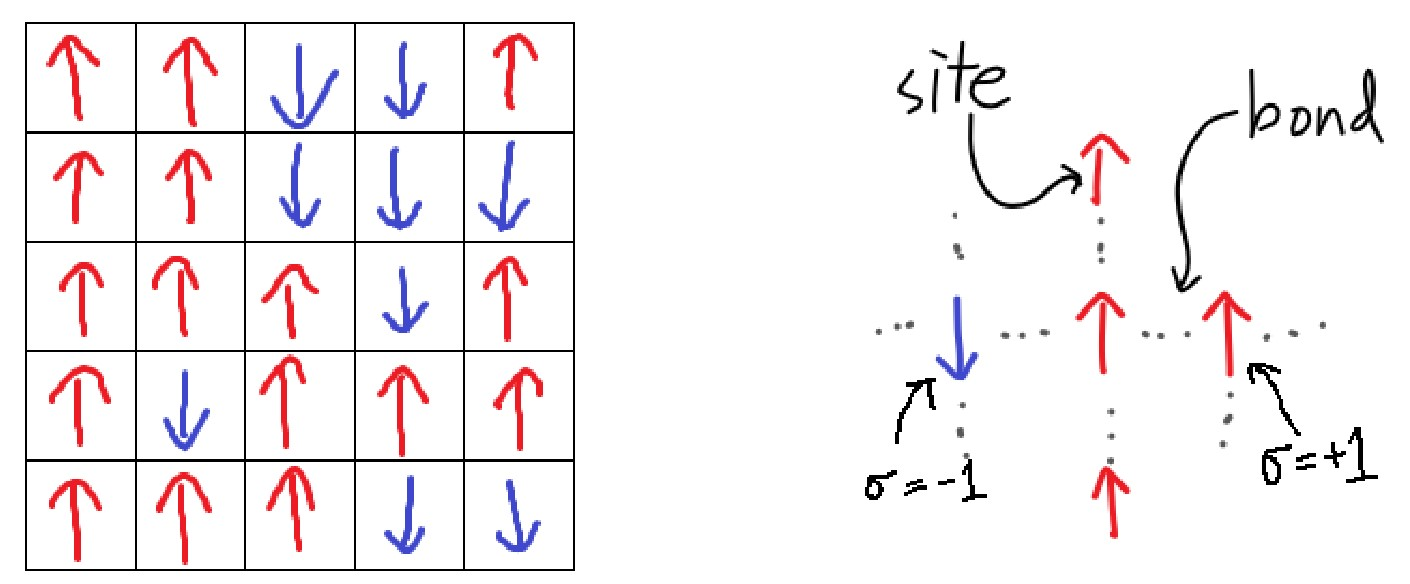

### Ising model in the presence of an external field: mathematical model

Consider a 2D Ising model, in which spins are located on a regular grid, with the same grid spacing in the $x$ and the $y$ direction, as in the cartoon. The $z$ direction is perpendicular to the grid. The energy of spin $i$ is given by

\begin{align}
E(s_{i}) = -\frac{J}{2} \sum\limits_{j} s_{i} s_{j} - \mu H s_{i}\,.
\end{align}

The first sum is the interaction energy of spin $i$, $s_i$, with its four nearest neighbours (off-set from the positon of spin $i$ by $\pm 1$ grid position in the $x$-direction and $\pm 1$ grid position in the $y$-direction of the Cartesian grid). The second term is the interaction of that spin with an external magnetic field, which is assumed to be perpendicular to the 2D grid (parallel to $z$). $J$ is a posivitve constant. The factor $1/2$ that appears in the first term is such that when we obtain the total energy by summing over all spins, $E=\sum_i E(i)$, we count each *pair* only once.
We will further assume that the grid is **periodic**, both in $x$ and in $y$.

We further assume that the spin itself is dimensionless and can only take the values $+1$ or $-1$, that is, the spin direction points either vertically up, or vertically down compared to the 2D grid. Given that $s$ is dimensionless, $J$ and $\mu H$ both have the dimension of energy - since $E$ is an energy. To simplify the calculation, 
we define a `critical temperature`, $T_c$ and a `critical magnetic field`, $H_c$, by the relations

\begin{align}
k_BT_c\equiv 2J\equiv \mu H_c\,,
\end{align}
where $k_B$ is Boltzmann's constant. The energy of a single spin can then be written as

$$
E(s_i) = -k_B\,T_c\,\left(\frac{1}{4}\sum_\limits{j} s_j\,+\frac{H}{H_c}\right)\,s_i\quad\quad (1)
$$
and the total energy
$$
E = \sum_i\,E(s_i)\,.\quad\quad (2)
$$

In our modelling, we will characterise the spin system by the constant $k_BT_c\equiv \mu H_c\equiv 2J$.



## Part 1: Mean-Field approximation

In the mean-field approximation, we assume that all spins have the same (mean) value, $\langle s\rangle$, except the particular spin $i$ that we are examining. In this case, the energy of spin $s_i$ is given by

$$
E(s_i) = -k_B\,T_c\,\left(\langle s\rangle\,+\frac{H}{H_c}\right)\,s_i\equiv - \mathcal{H}_{\rm eff}s_i\,,\quad\quad (3)
$$
since each spin has 4 nearest neighbours. We also defined the `effective` magnetic field
as $\mathcal{H}_{\rm eff}\equiv k_B T_c\,\left(\langle s\rangle\,+\frac{H}{H_c}\right)$.
Notice that for the spin-spin interaction energy between spins $i$ and $j$, $k_B\,T_c s_i s_j$, we have used the mean value of the spin $\langle s\rangle$ for the neighbouring spins of spin $i$. This is the essence of the mean-field approximation.

The probability for a spin to have a given value ($s=1$ or $s=-1$) depends on temperature, $T$, and is given by the Boltzmann factor. This probability is ${\cal P}(s_i)=A\exp(-E(s_i)/k_BT)$, where $A$ is a normalization factor. Therefore for spin up ($s_i=1$) and spin down ($s_i=-1$), the respective probabilities are
$$
{\cal P}(+1)=A\exp(\mathcal{H}_{\rm eff}/k_BT)\,;\quad {\cal P}(-1)=A\exp(-\mathcal{H}_{\rm eff}/k_BT)
$$

We can determine the normalization $A$ by requiring that ${\cal P}(+1)+{\cal P}(-1)=1$: since no other spin states are possible, the spin is either up or down. Therefore the mean spin is

$$
\langle s\rangle = \frac{{\cal P}(+)-{\cal P}(-)}{{\cal P}(+)+{\cal P}(-)}
$$
and substituting for the probabilities yields
$$
\langle s\rangle=\tanh\left\{\frac{T_c}{T}  \left(\langle s\rangle + \frac{H}{H_c}\right) \right\}\,.\,\quad\quad (4)
$$

As also discussed in the lecture, for give values of $T$ and $H$, this is an equation for $\langle s\rangle$ which can be solved numerically. It has either one, two or three roots. In the case of three roots,
the lowest and highest value correspond to organised spin states, where most spins point down or up. Part 1 consists of implementing this mean-field (MF) approximation and examining its behaviour for various values of $T/T_c$ and $H/H_c$.

The mean magnetisation per spin, $M/N$, and the mean energy per spin, $E/N$, are
$$
M/N = \langle s\rangle\,;\quad E/N=-k_B\,T_c\,\left(\langle s\rangle\,+\frac{H}{H_c}\right)\,\langle s\rangle\,.
$$

Here, $M$ is, of course, the total magnetisation of the system, and $E$ the total energy.

The **heat capacity** of a system is given by $C \equiv \frac{dE}{dT}$, therefore the heat capacity per spin is

$$
C/N = \frac{dE/N}{dT}\,.
$$

In the figures below, we will plot $M/N$ to obtain the mean dimensionless magnetisation per spin, $E/Nk_BT_c$ to obtain the mean dimensionless energy per spin, and $C/N k_B$, the mean dimensionless heat acapacity per spin.




## **Important**

In the absence of an external field, the up direction and the down direction cannot be distinguished (they are equivalent). Therefore, to determine whether the spin system is magnetized, a value of +1 or of -1 *both* indicate
a very high level of magnetization. In other words: when the value of the external field is $H=0$, it only makes sense to compute *the absolute value of the mean magnetization*. When $H\neq 0$, it does make sense to also look at the sign of the magnetization as well.


### Define a class, MF, that encodes the mean-field solution and some of the methods to examine the Ising model

For simplicity, we will set $k_B=\mu=1$, so that $T_c=2J=H_c$.

In [11]:
class MF:
    def __init__(self, Tc, T, H):
        # set-up the values for this system
        self.Tc = Tc
        self.T  = T
        self.H  = H
        self.Hc = Tc    # by definition
        
    def energy(self, s):
        # implement the energy Equation (3), given the input value s=s_i=<s>
        # input: s=<s>=s_i
        # output: E(s_i) (Equation 3)
        energy = 0. # initialize
        # YOUR CODE HERE
        k_B = 1
        energy = - k_B * self.Tc * (s + self.H / self.Hc) * s
        return energy

    def mf(self, s):
        # implement the right-hand side of Equation (4), given the input value of s=<s>
        # input: s=<s>
        # output: right hand side of Equation 4
        rhs = 0. # initialize
        # YOUR CODE HERE
        rhs = np.tanh(self.Tc / self.T * (s + self.H / self.Hc))
        return rhs
    
    # root finders    
    def bisection(self, s1, s2):
        # Implement root finding for Equation (4), using the bi-section method.
        # The routine should return the root of Equation (2), bracketed by s1 and s2
        # The root shoud be such that the error err = |<s>-tanh( (Tc/T) * (<s>+H/Hc) )| < tol
        # input: s1, s2 that bracket a root of Equation (2)
        # output: root, err, it
        #      root: value of the root
        #      err:  error, err=|<s>-tanh( (Tc/T) * (<s>+H/Hc) )|
        #      it:   number of iterations in the bisection step

        # Initialize
        tol     = 1e-8  # required tolerance
        root    = 0.0     # value of the root
        err     = 1e10    # error on the root
        it      = 0       # number of iterations in the bisection step
        nitmax  = 1e8     # maximum numbe of iterations
        # Consistency check: verify that s1 and s2 bracket root
        fs1 = s1 - self.mf(s1)
        fs2 = s2 - self.mf(s2)
        if fs1 * fs2 > 0:
            print("Error: input values do not bracket root")
        else:
        # YOUR CODE HERE
            while it < nitmax:
                root = (s1 + s2) / 2.0
                f_root = root - self.mf(root)
                err = abs(f_root)
                
                if err < tol:
                    return root, err, it
                
                if fs1 * f_root < 0:
                    s2 = root
                    fs2 = f_root
                else:
                    s1 = root
                    fs1 = f_root
                    
                it += 1
        
            return root, err, it

        
    def MultiRoot(self, ntest=100):
        # Find all roots of equation (4) by dividing the interval of physical roots, [-1,1],
        #    in ntest equal intervals        

        # create intervals
        test_root =  2./ntest
        s_min     = -1.
        s_max     =  1. + test_root
        test_root = np.arange(s_min, s_max, test_root)
        
        # look for zeros of Equation (2)
        zeros     = test_root - self.mf(test_root)
        allroots  = []
        
        # Identify all intervals that bracket a root. If such an interval is found, identify the root using bisection
        left_bracket  = test_root[0]
        left_value    = zeros[0]
        for (root, zero) in zip(test_root, zeros):
            right_bracket = root
            right_value   = zero
            if (left_value * right_value < 0):
                # find root by dissection
                root, err, it = self.bisection(left_bracket, right_bracket)
                allroots.append(root)
            # prepare for doing next interval
            left_bracket = right_bracket
            left_value   = right_value
        return allroots
    
    def TestRoot(self, root):
        return root - self.mf(root)

In [12]:
# test 1: you can use these tests to verify your implementation (no marks)

# 
Tc  = 1; Hc = Tc
#
T = 0.4 * Tc; H = 0* Hc; s = -0.2; mf = MF(Tc, T, H)
print(" Your energy = ", mf.energy(s), " ; correct value = -0.040 (2sf)")
T = 0.4 * Tc; H = 0.3 * Hc; s = 0.2; mf = MF(Tc, T, H)
print(" Your energy = ", mf.energy(s), " ; correct value = -0.10 (2sf)")

# Bisection implementation test
T  = 0.1; H = 0.5 * Hc; mf = MF(Tc, T, H)
s1 = -1.1; s2 = -0.8
print("Bisection: your root is ", mf.bisection(s1, s2)[0], " ; correct answer = -1.0 (2sf)")

# MultiRoot implementation test
T = 0.1; H = 0.5 * Hc; mf = MF(Tc, T, H)
print("MultiRoot: your roots are ", mf.MultiRoot())
# for root in (-1, -0.5638452959060666, 1):
#     error = mf.TestRoot(root)
#     print(root, error)
print("Correct answer is [-1, -0.56, 1.0] (to 2 sig figs)")

 Your energy =  -0.04000000000000001  ; correct value = -0.040 (2sf)
 Your energy =  -0.1  ; correct value = -0.10 (2sf)
Bisection: your root is  -0.999909043312073  ; correct answer = -1.0 (2sf)
MultiRoot: your roots are  [-0.9999090385437013, -0.5638453006744382, 0.9999999904632586]
Correct answer is [-1, -0.56, 1.0] (to 2 sig figs)


Next cell is for **6 marks**

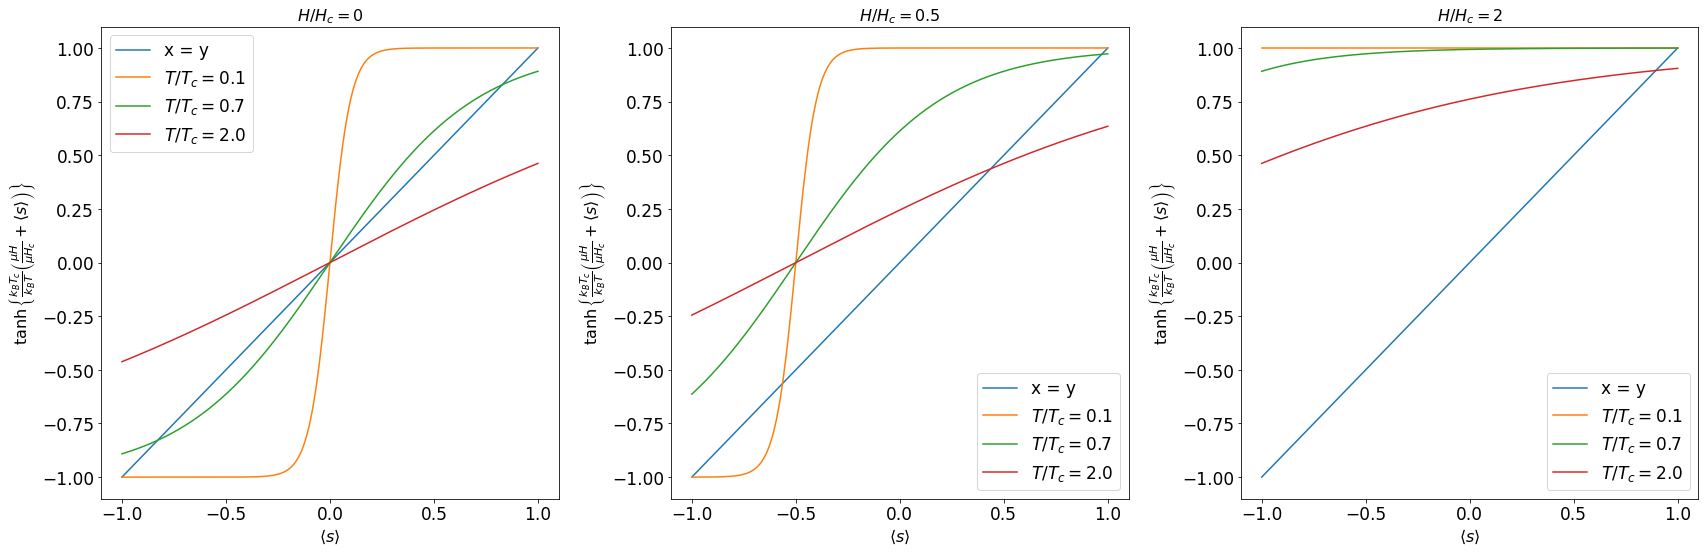

In [13]:
# test 2: 
Tc         = 1    # normalization
Hc         = Tc   # by definition

# Compute and plot right-hand-size (rhs) of equation 4, for the cases
# H=[0, 0.5, 2]    * Hc
# T=[0.1, 0.7, 2]  * Tc
# and for a range of spin values, <s>, in the range [-1,1]
# Make a seperate plot for each value of H, and use a legend to distinguish the different values of T
# On each plot, superpose the line where the rhs = <s>. This line intersects the rhs at the roots of Equation 2
# You can verify your answer by comparing to the solution in the next cell
# Add a title to each plot, as well as x and y-axis labels

# YOUR CODE HERE
H_values = [0, 0.5, 2]
T_values = [0.1, 0.7, 2]

s_values = np.linspace(-1, 1, 500)

fig, axs = plt.subplots(1, 3, figsize=(24, 8))

for i,H in enumerate(H_values):
    ax = axs[i]
    ax.plot(s_values, s_values, '-', label="x = y")
    
    for T in T_values:
        mf_model = MF(Tc=Tc, T=T, H=H)
        
        rhs_values = [mf_model.mf(s) for s in s_values]
        
        ax.plot(s_values, rhs_values, label = rf"$T/T_c = {T: .1f}$")
    
    ax.legend()
    ax.set_title(f"$H/H_c = {H}$")
    ax.set_xlabel(r"$\langle s \rangle$")
    ax.set_ylabel(r"$\tanh\left\{\frac{k_BT_c}{k_BT} \left(\frac{\mu H}{\mu H_c} + \langle s \rangle\right)\right\}$")
    
plt.tight_layout()
plt.show()

You may want to test your answer and implementation by comparing to the plots below.

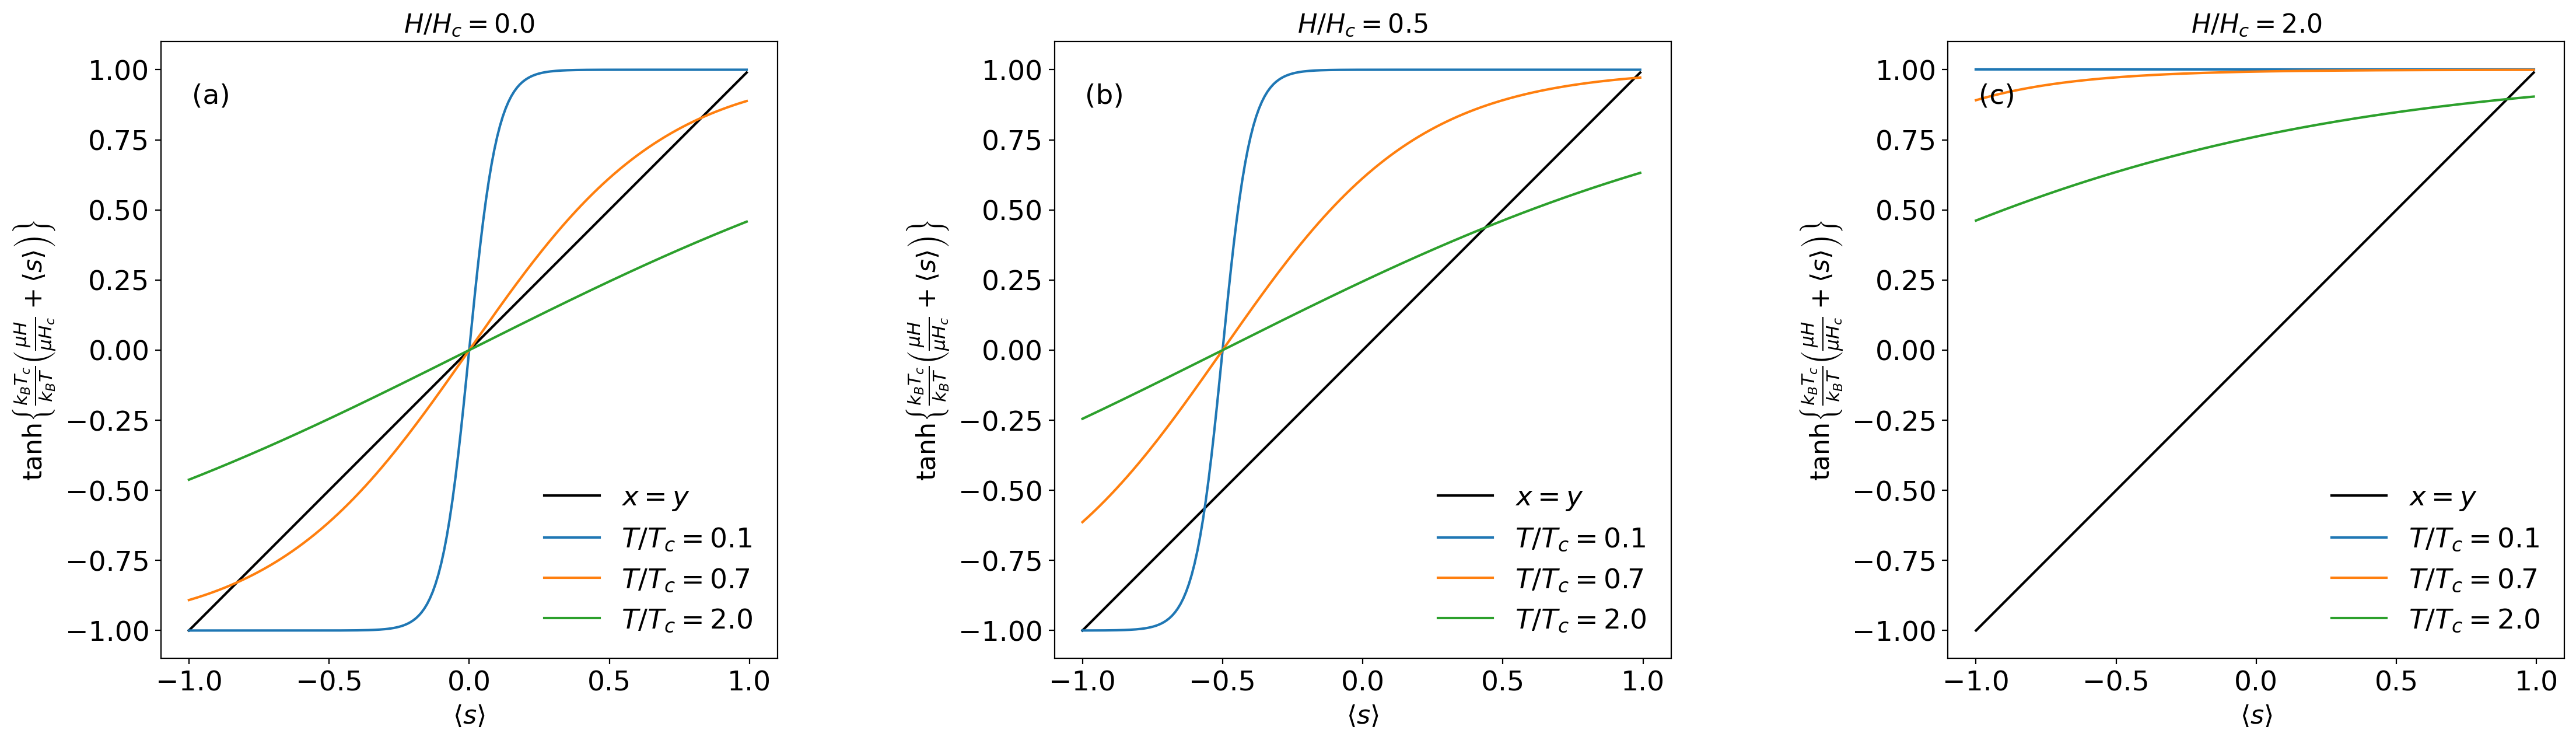


In [14]:
# Here you may test your multiroot implementation against the answers provided (no marks)
Tc     = 1.0
values = ((0.8, 0), (1.8, 0.05), (2.0, 2.0))
for value in values:
    T     = value[0]
    H     = value[1]
    mf    = MF(Tc, T, H)
    root  = mf.MultiRoot()[-1]
    error = mf.TestRoot(root)
    info  = r"Multiroot: for T={0:2.2f} and H={1:2.2f} your root is {2:1.8f}, error= {3:1.8e}".format(T, H, mf.MultiRoot()[-1], error)
    print(info)
result = (0.7104117823, 0.062318064800623824, 0.8952191973)
print(" correct roots are: {0:1.8f}, {1:1.8f}, {2:1.8f}".format(result[0], result[1], result[2]))

Multiroot: for T=0.80 and H=0.00 your root is 0.71041176, error= -9.54616497e-09
Multiroot: for T=1.80 and H=0.05 your root is 0.06231808, error= 5.48729988e-09
Multiroot: for T=2.00 and H=2.00 your root is 0.89521919, error= -3.31003780e-09
 correct roots are: 0.71041178, 0.06231806, 0.89521920


Now answer the qeustions below. Each correct answer is worth **2 marks**. You may want to use the cells below to compute the answers.

Note that in some cases $H=0$, in which case only specify **the absolute value** of $\langle s\rangle$.

In [61]:
label  = r"For $T_c=1$, $T=0.1T_c$, $H=0$, the largest root is (to 6 sf)"
label2 = r"$\langle s\rangle_{\rm max} = $"
MF1=mywidgets.myFloatBox('MF1','NL',label2,label)
MF1.getWidget()

In [16]:
# display(HTML('<hr>'))

In [62]:
label  = r"For $T_c=1$, $T=0.5T_c$, $H=0.1 T_c$, the largest root is (to 6 sf)"
label2 = r"$\langle s\rangle_{\rm max} = $"
MF2=mywidgets.myFloatBox('MF2','NL',label2,label)
MF2.getWidget()

In [18]:
#display(HTML('<hr>'))

In [63]:
label  = r"For $T_c=1$, $T=2T_c$, $H=2T_c$, the largest root is (to 6 sf)"
label2 = r"$\langle s\rangle_{\rm max} = $"
MF3=mywidgets.myFloatBox('MF3','NL',label2,label)
MF3.getWidget()

In [20]:
# display(HTML('<hr>'))

In [21]:
# You may want to use this cell to compute the answers to the questions above
# YOUR CODE HERE

test1 = [1, 0.1, 0]
test2 = [1, 0.5, 0.1]
test3 = [1, 2, 2]

def compute_root(test):
    Tc, T, H = test
    mf_model = MF(Tc=Tc, T=T, H=H)
    roots = mf_model.MultiRoot(ntest=1000)
    largest_root = max(roots)
    return largest_root

print(f"{compute_root(test1):.6g}")
print(f"{compute_root(test2):.6g}")
print(f"{compute_root(test3):.6g}")

1
0.973016
0.895219


The following cell is worth **12 marks**

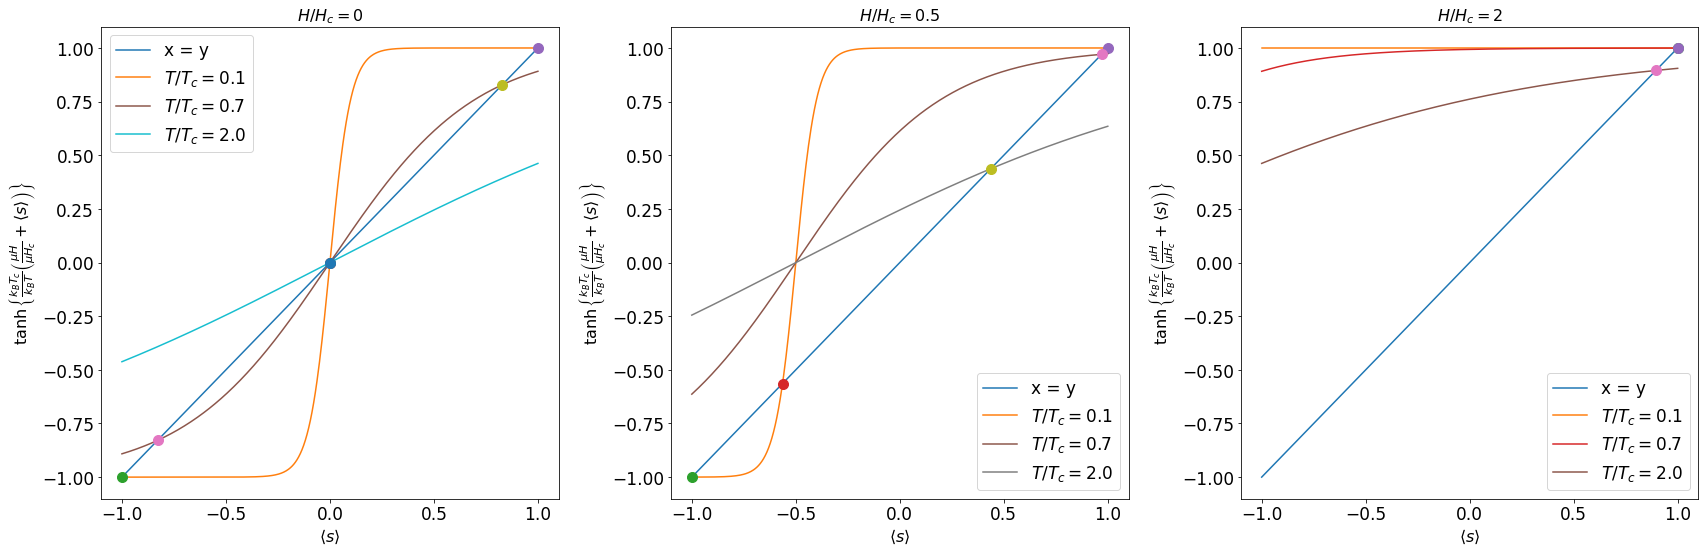

In [22]:
# Now redo test 2
Tc         = 1    # normalization
Hc         = Tc   # by definition

# Compute and plot right-hand-size (rhs) of equation 4, for the cases
# H=[0, 0.5, 2]    * Hc
# T=[0.1, 0.7, 2]  * Tc
# and for a range of spin values, <s>, in the range [-1,1]
# Make a seperate plot for each value of H, and use a legend to distinguish the different values of T
# On each plot, superpose the line where the rhs = <s>. This line intersects the rhs at the roots of Equation 4
# You can verify your answer by comparing to the solution in the next cell
# Add a title to each plot, as well as x and y-axis labels

# In addition, add all roots for each value of T, to each plot.
Tc         = 1    # normalization
Hc         = Tc   # by definition

# YOUR CODE HERE
H_values = [0*Hc, 0.5*Hc, 2*Hc]
T_values = [0.1*Tc, 0.7*Tc, 2*Tc]

s_values = np.linspace(-1, 1, 500)

fig, axs = plt.subplots(1, 3, figsize=(24, 8))

for i, H in enumerate(H_values):
    ax = axs[i]
    ax.plot(s_values, s_values, '-', label="x = y")
    
    for T in T_values:
        mf_model = MF(Tc=Tc, T=T, H=H)
        rhs_values = [mf_model.mf(s) for s in s_values]
        ax.plot(s_values, rhs_values, label=rf"$T/T_c = {T:.1f}$")
        
        roots = mf_model.MultiRoot(ntest=1000)
        for root in roots:
            ax.plot(root, mf_model.mf(root), 'o', markersize=10, label='')
    
    ax.legend()
    ax.set_title(f"$H/H_c = {H}$")
    ax.set_xlabel(r"$\langle s \rangle$")
    ax.set_ylabel(r"$\tanh\left\{\frac{k_BT_c}{k_BT} \left(\frac{\mu H}{\mu H_c} + \langle s \rangle\right)\right\}$")
    
plt.tight_layout()
plt.show()



You may want to compare your answer to my version,

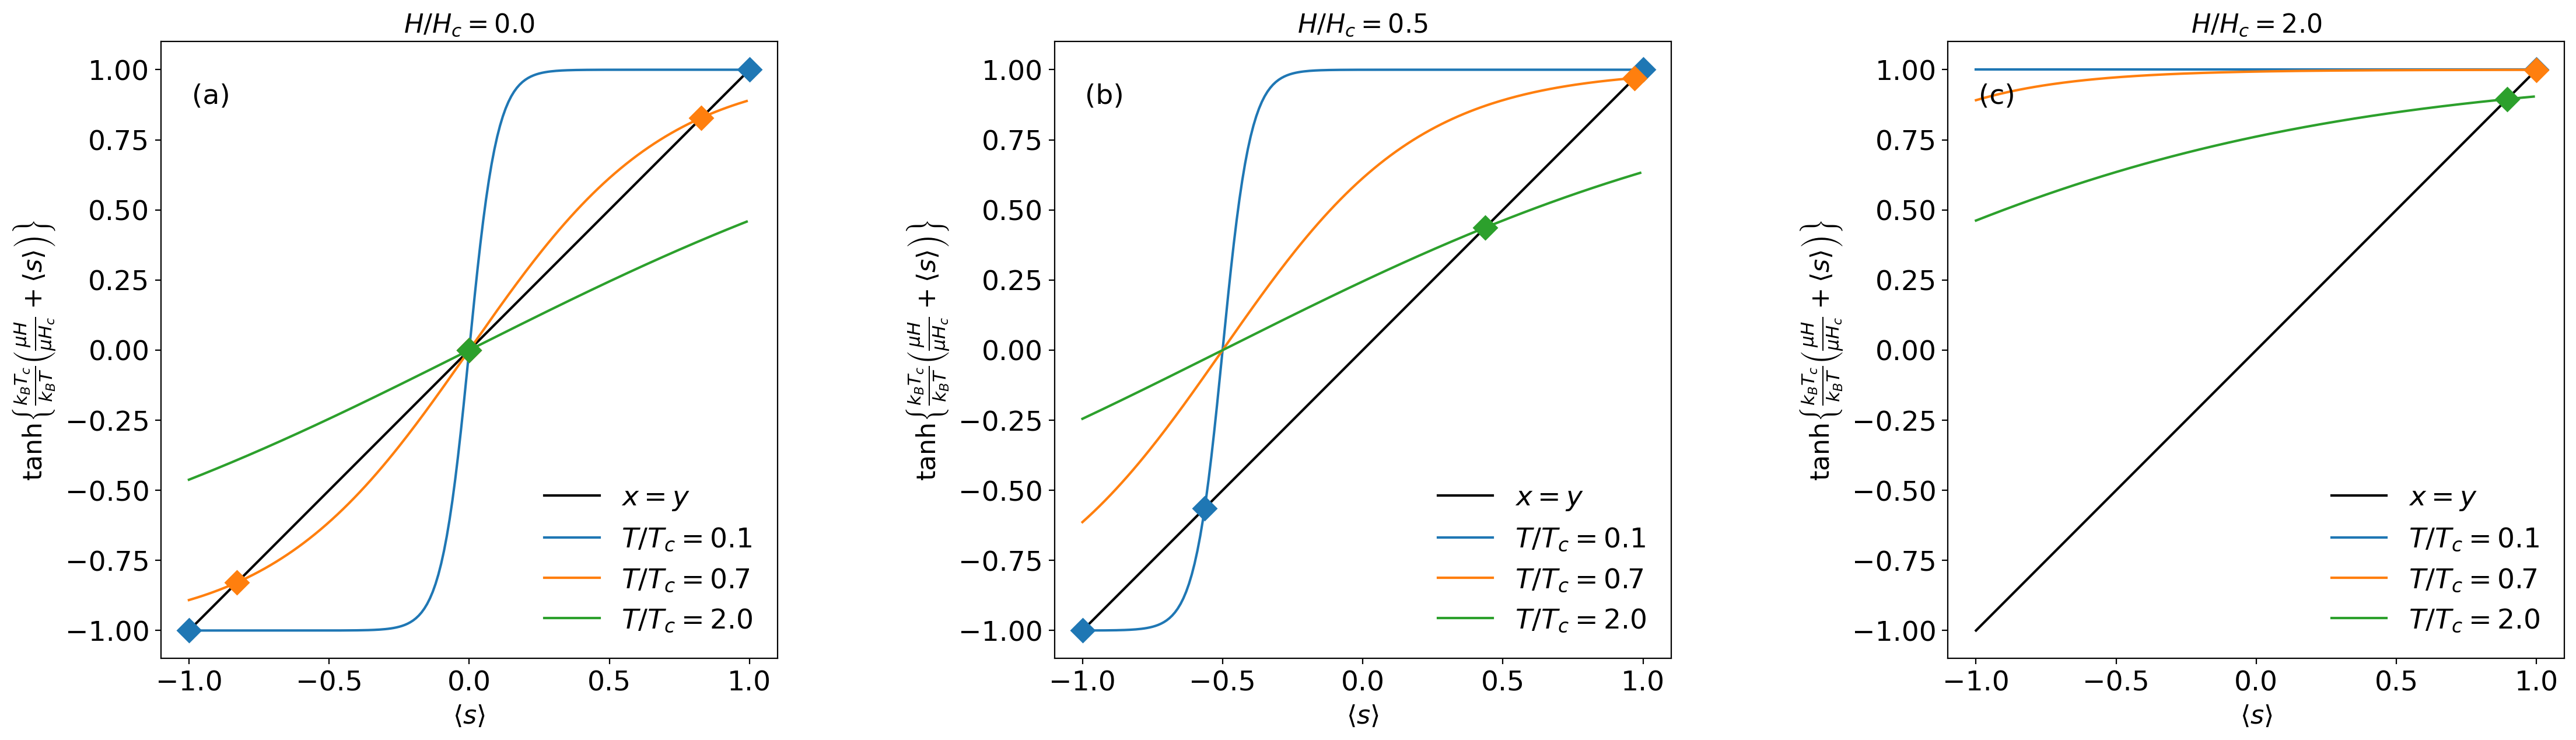


The following cell is worth **12 marks**.

Maximum C/N for H/H_c =  0.0: 2.4819812866954094
Maximum C/N for H/H_c =  0.5: 0.9956927941345759
Maximum C/N for H/H_c =  2.0: 0.6465707675122756


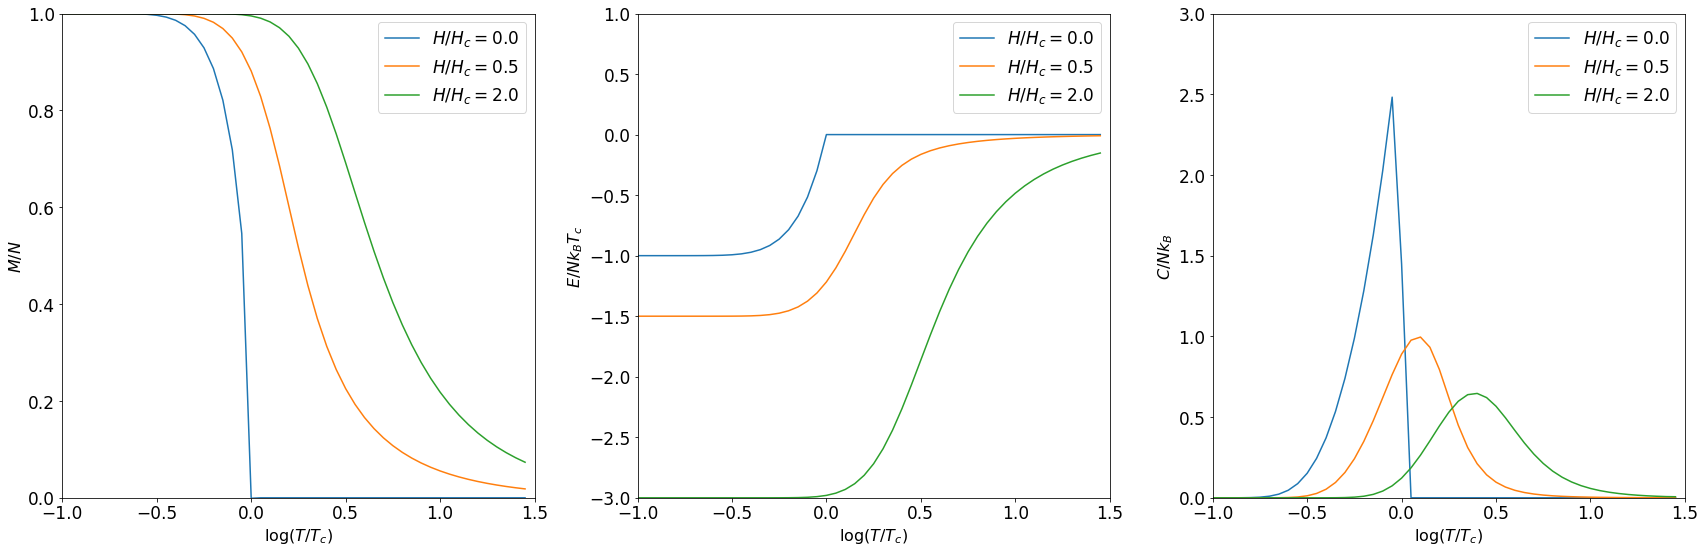

Calculation finished


In [23]:
# Make a three panel plot
# In each panel, plot three curves, corresponding to H/H_c=0, 0.5 and 2
#
# Panel (a): compute and plot the mean magnetisation per spin, M/N, as a function of log(T/T_c)
# Panel (b): compute and plot the mean energy per spin, E/N, as a function of log(T/Tc)
# Panel (c): compute and plot the mean heat capacity per spin, C/N k_B, as a function of log(T/Tc)

# Briefly describe how you compute C numerically, given E(T).

# In all cases, plot the temperature as log(T/T_c), where log is the logarithm with base 10
# Plot axes labels and legends on each diagram

# 
Tc         = 1    # normalization
Hc         = Tc   # by definition
Ts         = 10**(np.arange(-1,1.5,0.05)) * Tc  # Use these values for the temperature

# YOUR CODE HERE
H_values = [0*Hc, 0.5*Hc, 2*Hc] 
log_T_over_Tc = np.log10(Ts / Tc)

fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Panel a
for H in H_values:
    M_per_spin = []
    for T in Ts:
        mf_model = MF(Tc=Tc, T=T, H=H)
        roots = mf_model.MultiRoot(ntest=1000)
        M_per_spin.append(max(roots))
    axs[0].plot(log_T_over_Tc, M_per_spin, label=rf"$H/H_c = {H: .1f}$")
axs[0].set_xlabel(r"$\log(T/T_c)$")
axs[0].set_ylabel(r"$M/N$")
axs[0].set_xlim(-1, 1.5)
axs[0].set_ylim(0, 1)
axs[0].legend()

# Panel b
for H in H_values:
    E_per_spin = []
    for T in Ts:
        mf_model = MF(Tc=Tc, T=T, H=H)
        roots = mf_model.MultiRoot(ntest=1000)
        s_avg = max(roots)
        E_per_spin.append(-Tc * (s_avg + H / Hc) * s_avg)
    axs[1].plot(log_T_over_Tc, E_per_spin, label=rf"$H/H_c = {H: .1f}$")
axs[1].set_xlabel(r"$\log(T/T_c)$")
axs[1].set_ylabel(r"$E/Nk_BT_c$")
axs[1].set_xlim(-1, 1.5)
axs[1].set_ylim(-3, 1)
axs[1].legend()

# Panel c
for H in H_values:
    E_per_spin = []
    # compute E/N
    for T in Ts:
        mf_model = MF(Tc=Tc, T=T, H=H)
        roots = mf_model.MultiRoot(ntest=1000)
        s_avg = max(roots)
        E_per_spin.append(-Tc * (s_avg + H / Hc) * s_avg)

    # # C/E = d(E/N) / dT
    # # d(E/N) / dT approx [E/N(T_i+1) - E/N(T_i-1)] / [T_i+1 - T_i-1]
    # C_per_spin = []
    # for i in range(1, len(Ts) - 1):
    #     dE_dT = (E_per_spin[i+1] - E_per_spin[i-1]) / (Ts[i+1] - Ts[i-1])
    #     C_per_spin.append(dE_dT)

    # # Use the mid points
    # T_mid = log_T_over_Tc[1:-1]
    # axs[2].plot(T_mid, C_per_spin, label=rf"$H/H_c = {H: .1f}$")
    
    # Use np.gradient to compute C/N
    C_per_spin = np.gradient(E_per_spin, Ts)
    
    axs[2].plot(log_T_over_Tc, C_per_spin, label=rf"$H/H_c = {H: .1f}$")
    
    # compute the next question
    max_C_per_spin = max(C_per_spin)
    print(f"Maximum C/N for H/H_c = {H: .1f}: {max_C_per_spin}")
axs[2].set_xlabel(r"$\log(T/T_c)$")
axs[2].set_ylabel(r"$C/Nk_B$")
axs[2].set_xlim(-1, 1.5)
axs[2].set_ylim(0, 3)
axs[2].legend()

plt.tight_layout()
plt.show()

print("Calculation finished")

You may want to compare your answer to my solution,

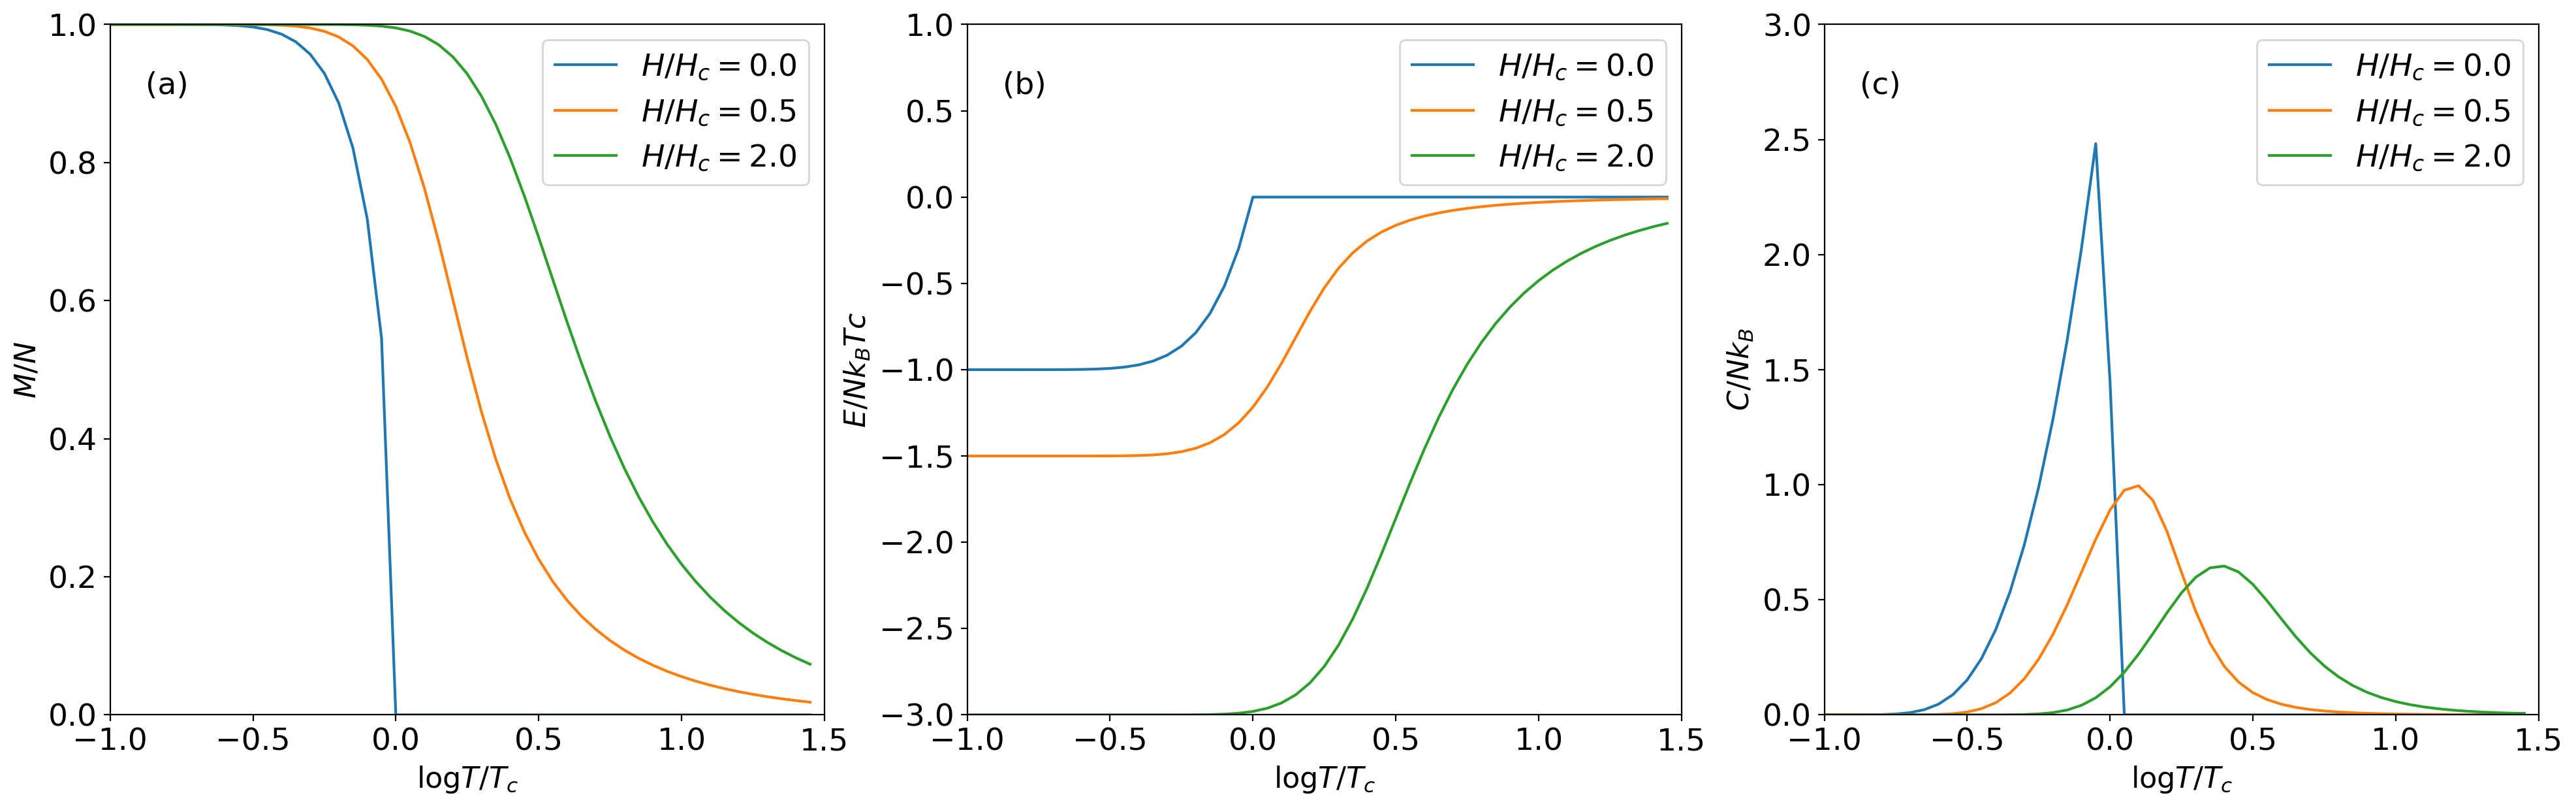

The following cell is worth **4 marks**

In [64]:
label  = r"For $T_c=1$, $H=2T_c$, compute the maximum value of C/N (to 2 significant figures)"
label2 = r"$(C/N)_{\rm max} = $"
MFC=mywidgets.myFloatBox('MFC','NL',label2,label)
MFC.getWidget()

## Part 2: Monte Carlo simulation of 2D Ising model

We will place spins on a regular, square, 2D lattice of specifed linear extent (`size`). The system is characterised by its value of the critical temperature `T_c`, the value of the applied field, `H`, and the temperature, `T`. These are all inputs to the class `Grid`, defined in the next cell. Spins interact with their nearest-neighbours only.
This means that a spin at location $(i,j)$ interacts with the spins at locations $(i-1,j)$, $(i+1,j)$, $(i,j-1)$ and $(i,j+1)$. We impose **periodic boundary conditions** - meaning that, for example, spin $(0,4)$ interacts with
spin $(size-1,4)$, as well as $(1,4)$, $(0,3)$ and $(0,5)$.

You will need to complete some of the definitions in the class `Grid`, in particular
 - complete the method to calculate the energy of a given spin
 $E_{\rm current} = -T_c\,\left(\frac{1}{4}\sum_j s_j + \frac{H}{H_c}\right)\,s_i$. (The sum is over the four nearest-neighbours of the spin.)
 - compute the energy, $E_{\rm flip}$, if (only) that spin $i$ were flipped, $s_i\rightarrow -s_i$.
 - sweep over the lattice in red-black ordering (see notes)
 - considering each spin in turn, decide whether to flip that spin or not, based on $\Delta E=E_{\rm flip}-E_{\rm current}$:
     - if $\Delta E<0$: flip the spin (spin prefers lower energy state)
     - if $\Delta E>0$: flip the spin, provided $\exp(-\Delta E/(k_BT))>r$, otherwise don't flip the spin  (thermal aggitation flips the spin)
     
Here, $r$ is a uniform random number $r\in [0,1[$ - draw a different random number every time. Notice that during a single sweep, potentially all spins may be flipped. We also use units such that $k_B=1$.


We initialize the lattice by assigning spins =1 or =-1, with equal probability (i.e. randomly). This means that we start the calculation in a state which may not reflect the expected level of ordering in the spins. Therefore, we wil start the calculation by executing a number of sweeps, called $n_{\rm therm}$, where we sweep over the lattice without doing any measurements (that is, we will flip spins as usual, but not use these initial sweeps to measure for example $M/N$.). This will allow the spins to settle in the state expected at the temperature $T$ of the lattice. This is called the ` thermalization stage`. Once these sweeps are completed, we will perform another $n_{\rm measure}$ sweeps, during which we measure the properties of the spins, such as for example, $M/N$, the mean magnetisation per spin.



 




### Below we define a class Grid, that is going to be the basis for the simulation of the Ising model

In [25]:
class Grid:
    def __init__(self, Tc=1, T=1, H=0, size=32, cells=None):
        '''This function sets value of of the critical temperature (Tc), 
        temperature (T) and external magnetic field (H).
        If cells are set to None, the function
        initialises the grid, i.e. it sets the 
        grid size, and initialises the cells of the 
        grid with randomly chosen 'plus' (1) or 'minus' (-1) spin states.
        If size is not none, the size and cells are taken from the input of the function'''
        self.Tc    = Tc
        self.Hc    = Tc     # by definition
        self.T     = T
        self.H     = H
        
        if np.sum(cells)==None:
            # Generate random grid with random spins
            self.size  = size
            self.cells = np.zeros((size, size))
            for i in np.arange(self.size):
                for j in np.arange(self.size):
                    # randomly initialize spins as either up (cells=+1) or down (cells=-1)
                    self.cells[i, j] = np.random.choice((-1., 1.))
#                    self.cells[i, j] = -1
        else:
            # Use grid that was passed in
            # First perform consistency check
            Nx, Ny     = cells.shape
            if (Nx != size) or (Ny != size):
                print("error: specified size = ", size, " but actual size = ", Nx, Ny)
            self.size  = size
            self.cells = cells
                
    def energy(self, i, j):
        '''This function calculates the two energies,'e_current' and 'e_flip' for
        the spin located at the position [i,j] in the grid.
        e_current corresponds to the energy in its current spin state.
        e_flip corresponds to the energy if the spin were flipped
        The energy includes the contribution of the interaction with its four nearest-neighbours, as
        well as with the externally imposed magnetic field, see Equation 1 with k_B=1.
        Be sure to include periodic boundary conditions on the grid.
        Note that a particular spin (s_i in Eq 1), is identified with two Cartesian coordinates, here (i,j).
        Input: the location (i,j) of the cell for which we want to calculate the energy
        Output: e_current, e_flip: the energy of the spin, and - the spin.
        '''
        grid      = self.cells
        size      = len(grid)

        # current spin of this cell
        s_current = grid[i, j]
        # value of the spin if it were flipped
        s_flip    = -s_current

        
        # Compute the energy, e_current, of the spin in its current spin state.
        # Compute the energy, e_flip, of the spin if it were flippd
        e_current = 0.0  # Initialize values
        e_flip    = 0.0
        # YOUR CODE HERE
        neighbours = [
            grid[(i - 1) % size, j],
            grid[(i + 1) % size, j],
            grid[i, (j - 1) % size],
            grid[i, (j + 1) % size]
        ]

        e_current = -self.Tc * (sum(neighbours) * s_current / 4 + self.H / self.Hc * s_current)
        e_flip    = -self.Tc * (sum(neighbours) * s_flip    / 4 + self.H / self.Hc * s_flip)

        return e_current, e_flip
    
    def prob_flip(self, e_current, e_flip):
        '''This function calculates the probability of a spin flip 
        for a given spin, given the energies e_current and e_flip 
        of the current and the flipped state for the cell.
        returns: the probability for the flip
        if e_flip < e_current: probability_for_flip = 1
        if e_flip >= e_current: probability_for_flip = exp(-(e_flip-e_current)/k_BT).
        with k_B=1
        '''
        probability_for_flip = 0 # Initialize value
        # YOUR CODE HERE
        if e_flip < e_current:
            probability_for_flip = 1
        else:
            delta_e = e_flip - e_current
            probability_for_flip = np.exp(-delta_e / self.T)

        return probability_for_flip
    
    def sweep(self):
        '''This function carries out a single red-black sweep. 
        On a red-black checker board, this corresponds to running through all red cells, first by row, then by column,
        followed by running over all black cells, first by row, then by column
        For a given cell, we evaluate the probability to flip the spin, using self.prob_flip.
          if probability_for_flip > r, we flip the spin.
          Here, r is a random number, uniformly drawn in the interval [0,1[.
          Draw a different random number for each cell.
        The function returns the number of spin flips, and modifies the spin orientation of the cells.
        input: self
        output: number of spin flips
         '''
        nflips = 0
        # YOUR CODE HERE
        size = self.size
        grid = self.cells
        
        for i in range(size):
            for j in range(size):
                if (i + j) % 2 == 0:
                    e_current, e_flip = self.energy(i, j)
                    prob = self.prob_flip(e_current, e_flip)
                    if np.random.rand() < prob:
                        grid[i, j] *= -1
                        nflips += 1
    
        for i in range(size):
            for j in range(size):
                if (i + j) % 2 == 1:
                    e_current, e_flip = self.energy(i, j)
                    prob = self.prob_flip(e_current, e_flip)
                    if np.random.rand() < prob:
                        grid[i, j] *= -1
                        nflips += 1
        
        return nflips
    
                        
    def mean_magnetisation(self):
        '''This function calculates the mean magnetisation per spin, M/N.
        returns: the mean magnetisation M/N'''
        M = 0.0 # Initialize value
        # YOUR CODE HERE
        M = np.sum(self.cells) / (self.size * self.size)
        
        return M
    
    def mean_energy(self):
        '''This function calculates the mean energy per spin, E/N.
        returns: the mean energy E/N'''
        mean_energy = 0.0 # Initialize value
        # YOUR CODE HERE
        total_energy = 0
        for i in range(self.size):
            for j in range(self.size):
                e_current, _ = self.energy(i, j)
                total_energy += e_current
        mean_energy = total_energy / (self.size * self.size)
        
        return mean_energy
    
    def do_sweeps(self, n_therm=20, n_measure=500):
        '''This function carries out n_therm thermalisation sweeps and n_measure measurement sweeps.
        At the end of each measurement sweep the mean magnetisation and energy per spin are computed and recorded.
        input: the number of thermalisation sweeps, n_therm
               the number of measurement sweeps, n_measure
        output: a dictionary, with M/N, and E/N, for each of the n_measure measurements

        The function uses the function sweep, mean_magnitization, and mean_energy function'''
        mean_magnetisation = np.zeros(n_measure)
        mean_energy        = np.zeros(n_measure)
        
        # YOUR CODE HERE
        for _ in range(n_therm):
            self.sweep()
            
        for sweep_num in range(n_measure):
            self.sweep()
            mean_magnetisation[sweep_num] = self.mean_magnetisation()
            mean_energy[sweep_num]        = self.mean_energy()

        return {'Mean_magnetisation':mean_magnetisation, 'Mean_energy':mean_energy}

In [26]:
# Tc=1; T=1.3; H=0.2;size=16
# np.random.seed(30)
# ising  = Grid(Tc=Tc, T=T, H=H, size=size)
# n_therm   = 5
# n_measure = 10
# result = ising.do_sweeps(n_therm=n_therm, n_measure=n_measure)
# # output some values
# print("Energies are: ", ising.energy(2,2), ising.energy(1,0), ising.energy(0,0))
# print("M/N= ", result["Mean_magnetisation"][-1])
# print("E/N= ", result["Mean_energy"][-1])

# state  = {'ising':ising, 'result':result}

# # save the Grid as a pickle file
# with open('grid.pickle', 'wb') as handle:
#     pickle.dump(state, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
# Test your implementation by executing this cell

# we read-in a previously computed model
with open('grid.pickle', 'rb') as handle:
    restored = pickle.load(handle)
    ising_r    = restored["ising"]
    result_r   = restored["result"]


# Compute the energies of the spins at location (2,2), (1,0) and (0,0)
print("Your energies are: ", ising_r.energy(2,2), ising_r.energy(1,0), ising_r.energy(0,0))
print("The correct values are: (0.2, -0.2) (-0.7, 0.7) (1.2, -1.2)")
print("Your mean energy E/N is ", ising_r.mean_energy())
print("The correct answer is E/N=-0.246875")
print("Your mean magnetisation M/N = ", ising_r.mean_magnetisation())
print("The correct answer is M/N = 0.1796875")

Your energies are:  (0.2, -0.2) (-0.7, 0.7) (1.2, -1.2)
The correct values are: (0.2, -0.2) (-0.7, 0.7) (1.2, -1.2)
Your mean energy E/N is  -0.24687500000000023
The correct answer is E/N=-0.246875
Your mean magnetisation M/N =  0.1796875
The correct answer is M/N = 0.1796875


In [28]:
# Use this cell to perform all your simulations. We will compare the simulation model with the mean field model
# (no marks)
# Main parameters of the model
Tc         = 1    # normalization
Hc         = Tc   # by definition
size       = 32   # choose this size for the grid

# parameters of simulation
n_therm   = 20
n_measure = 100

# range of values to compute are the same as those for the Mean Field model
Ts       = 10**(np.arange(-0.4,0.7,0.1)) * Tc   # range of temperatures
Hs       = [0, 0.5, 2] * Hc                     # range of external magnetic fields

# time computation
start_time = time.time()
# For each value of H:
#   - generate a grid with random spins, with the given parameters, T=0.1 Tc and H=0
#   - warm-up the calculation by doing n_therm=100 sweeps, followed by n_measure=5 sweeps
#   Then
#     for each value of T
#        - restore the cells from the previous iteration
#        - perform n_therm=20, n_measure=100 sweeps
#        - record the value of the magnetisation and energy
#        - continue with the next value of T
#  Save your results in a dictionary, for example
#  Simulation = {}   # name of the dictionary
#  for H in Hs:      # loop over all values of H
#      Simulation[H] = {}      # create dictionary for this value of H
#      initialize Grid, and perform initial sweeps
#      for T in Ts:            # now loop over all values of T
#         Simulation[H][T] = {} # create dictionary for this value of H and T
#         ising  = Grid(Tc=Tc, T=T, H=H, size=size, cells=cells) # set-up grid, using cells from previous calucaltion
#         do sweeps
#         Now store the values computed
#         Simulation[H][T]["Mean_Mag"] = mean_magnetisation
#         Simulation[H][T]["Mean_Eng"] = mean_energy
#     Simulation[H]["Temperatures"] = Ts


# You may want to do something similar for the Mean Field calculation, which we will over plot

# The solution is provided here so you can examine the calculation method

# YOUR CODE HERE
Simulation = {}

for H in Hs:
    Simulation[H] = {}

    cells = None
    # ising = Grid(Tc=Tc, T=Ts[0], H=0, size=size, cells=cells) # for T = 10**(-0.4)
    # If T = Ts[0], the simulation points will be closer to the curve given by mf().
    # But the comment says with the given parameters, T=0.1 Tc and H=0
    # so still T = 0.1 * Tc here
    ising = Grid(Tc=Tc, T=0.1 * Tc, H=0, size=size, cells=cells) # for T = 0.1

    ising.do_sweeps(n_therm=100, n_measure=5)

    for T in Ts:
        Simulation[H][T] = {}

        ising = Grid(Tc=Tc, T=T, H=H, size=size, cells=ising.cells)

        results = ising.do_sweeps(n_therm=n_therm, n_measure=n_measure)

        Simulation[H][T]["Mean_Mag"] = np.mean(results["Mean_magnetisation"])
        Simulation[H][T]["Mean_Eng"] = np.mean(results["Mean_energy"])

    Simulation[H]["Temperatures"] = Ts

info = r"Calculation finished, cpu time was {0:2.1f} s".format(time.time() - start_time)
print(info)

Calculation finished, cpu time was 32.5 s


The following cell is worth **10 marks**

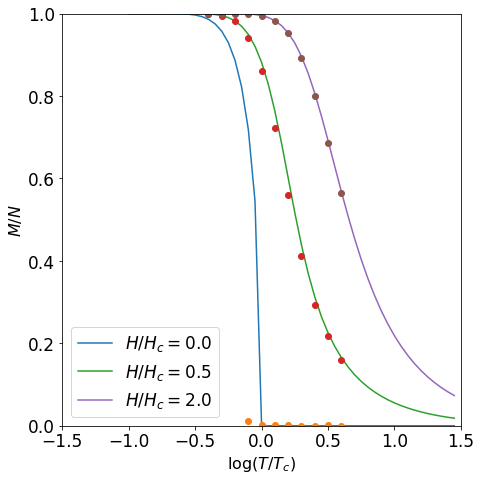

In [29]:
# plot mean magnetisation, M/N, for the model, as a function of log(T/T_c). Plot each value of H.
# Add a legend and x and y-axis labels.
# Overplot the mean field results for the same values of H
# Make sure that the plot and legend: 
#   - explain which curves correspond to which value of H
#   - explain which is the simulation result, and which is the mean field result


# make sure the figure is sufficiently large (7cm x 7cm) and that annotations are large enough to be read 

# marking scheme: axes labels 1
#                 correct looking curves for simulation  4
#                 correct curves for MF 4
#                 clear legend 1
fig, ax  = plt.subplots(1, 1, figsize = (7, 7))

# YOUR CODE HERE
Hs = [0, 0.5, 2]
Ts_mf = 10**(np.arange(-1,1.5,0.05)) * Tc

for i, H in enumerate(Hs):
    M_per_spin_MF = []
    for T in Ts_mf:
        mf_model = MF(Tc=Tc, T=T, H=H)
        roots = mf_model.MultiRoot(ntest=1000)
        M_per_spin_MF.append(max(roots))
    ax.plot(np.log10(Ts_mf / Tc), M_per_spin_MF, label=rf"$H/H_c = {H: .1f}$")

    M_per_spin_sim = [Simulation[H][T]["Mean_Mag"] for T in Ts]
    ax.plot(np.log10(Ts / Tc), M_per_spin_sim, "o", label="")


ax.set_xlabel(r"$\log(T/T_c)$")
ax.set_ylabel(r"$M/N$")
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(0, 1)
ax.legend()

plt.tight_layout()
plt.show()


You may want to compare the first figure to my solution,

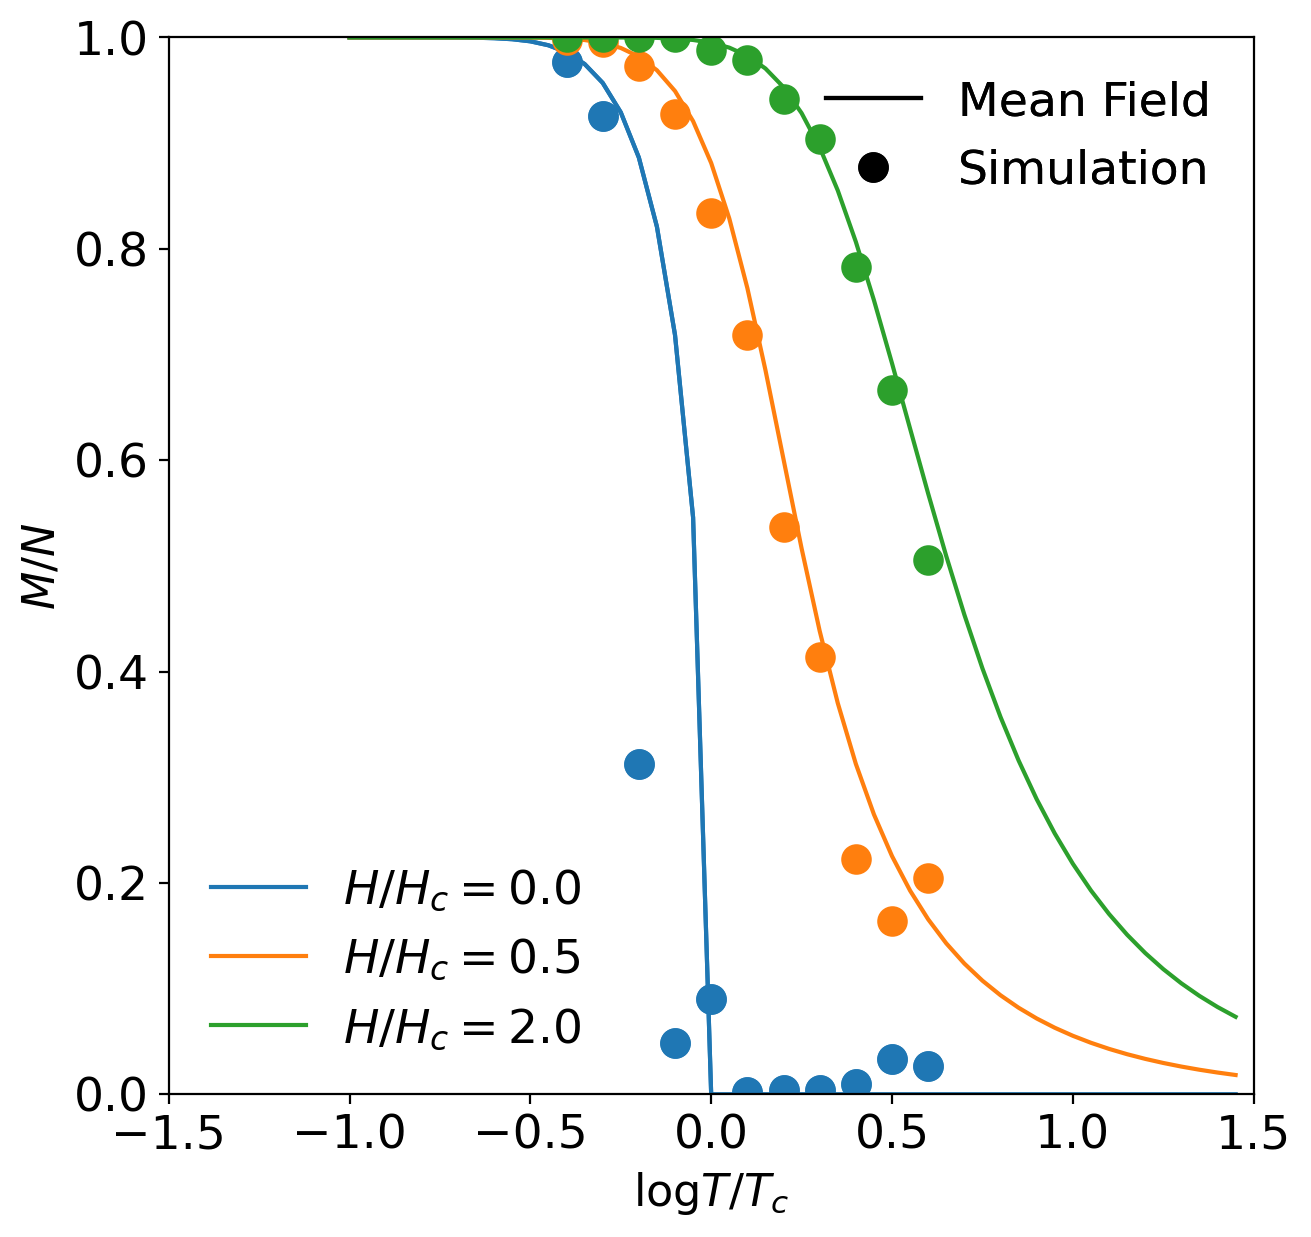

The following cell is worth **5 marks**

In [30]:
# Provide a short caption for your plot
# Write your answer as code comments, with each line starting with the "#" symbol

# YOUR CODE HERE

# This plot shows the mean magnetisation per spin M/N as a function of log(T/T_c) for different values of the external magnetic field H/H_c.
# The solid lines represent the predictions from the mean field model.
# The dots correspond to the results from the simulation.
# The curves and points show how the mean magnetisation varies with temperature for different strengths of the external magnetic field.

The following cell is worth **10 marks**.

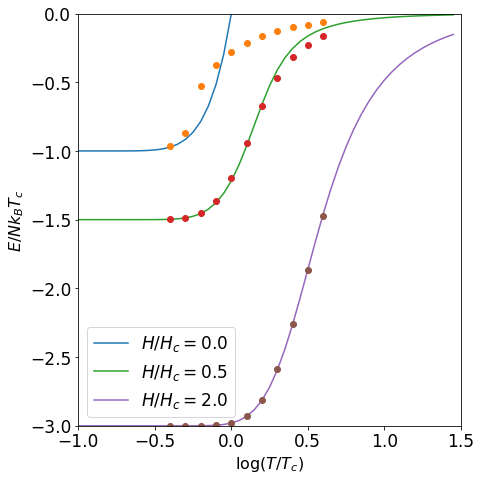

In [31]:
# As previous plot, but plotting mean energy per spin, E/N, for the model, as a function of log(T/T_c). Plot each value of H.
# Add a legend and x and y-axis labels.
# Overplot the mean field results for the same values of H
# Make sure that the plot and legend: 
#   - show which curves correspond to which value of H
#   - show which is the simulation result, and which is the mean field result


# make sure the figure is sufficiently large (7x7 cm) and that annotations are large enough to be read
# marking scheme: same as previous plot
# YOUR CODE HERE
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

Hs = [0, 0.5, 2]
Ts_mf = 10**(np.arange(-1, 1.5, 0.05)) * Tc

for i, H in enumerate(Hs):
    E_per_spin_MF = []
    for T in Ts_mf:
        mf_model = MF(Tc=Tc, T=T, H=H)
        roots = mf_model.MultiRoot(ntest=1000)        
        E_per_spin_MF.append(mf_model.energy(max(roots)))
    ax.plot(np.log10(Ts_mf / Tc), E_per_spin_MF, label=rf"$H/H_c = {H: .1f}$")

    E_per_spin_sim = [Simulation[H][T]["Mean_Eng"] for T in Ts]
    ax.plot(np.log10(Ts / Tc), E_per_spin_sim, "o", label="")

ax.set_xlabel(r"$\log(T/T_c)$")
ax.set_ylabel(r"$E/Nk_BT_c$")
ax.set_xlim(-1, 1.5)
ax.set_ylim(-3, 0)
ax.legend()

plt.tight_layout()
plt.show()



The following cell is worth **5 marks**

In [32]:
# Provide a short caption for your plot
# Write your answer as code comments, with each line starting with the "#" symbol

# YOUR CODE HERE

# This plot shows the mean energy per spin E/N as a function of log(T/T_c) for different values of the external magnetic field H/H_c.
# The solid lines represent the predictions from the mean field model.
# The dots correspond to the results from the simulation.
# The curves and points show how the mean energy varies with temperature for different strengths of the external magnetic field.

The following cell is worth **7 marks**

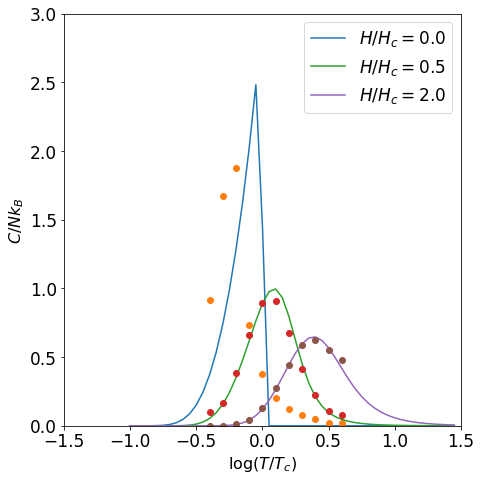

In [33]:
# Do the same as for the previous plot, but computing and plotting 
#   the specific heat capacity per spin, C = d(E/N)/dT
# Add a legend and x and y-axis labels.
# Overplot the mean field results for the same values of H
# Make sure that the plot and legend: 
#   - show which curves correspond to which value of H
#   - show which is the simulation result, and which is the mean field result
#  Explain how you compute CV

# make sure the figure is sufficiently large (7x7 cm) and that annotations are large enough to be read 
# YOUR CODE HERE
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

Hs = [0, 0.5, 2]
Ts_mf = 10**(np.arange(-1, 1.5, 0.05)) * Tc

for i, H in enumerate(Hs):
    E_per_spin_MF = []
    for T in Ts_mf:
        mf_model = MF(Tc=Tc, T=T, H=H)
        roots = mf_model.MultiRoot(ntest=1000)
        s_avg = max(roots)
        E_per_spin_MF.append(-Tc * (s_avg + H / Hc) * s_avg)

    # Use np.gradient to compute C/N
    C_per_spin_MF = np.gradient(E_per_spin_MF, Ts_mf)
    ax.plot(np.log10(Ts_mf / Tc), C_per_spin_MF, label=rf"$H/H_c = {H: .1f}$")

    E_per_spin_sim = [Simulation[H][T]["Mean_Eng"] for T in Ts]
    # Use np.gradient to compute C/N
    C_per_spin_sim = np.gradient(E_per_spin_sim, Ts)
    ax.plot(np.log10(Ts / Tc), C_per_spin_sim, "o", label="")

ax.set_xlabel(r"$\log(T/T_c)$")
ax.set_ylabel(r"$C/Nk_B$")
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(0, 3)
ax.legend()

plt.tight_layout()
plt.show()


# describe how you compute C from E and T
# C/N = dE/N / dT
# We could use np.gradient to find the dE/T and dT from E/T and T

The following cell is worth **3 marks**

In [34]:
# Provide a short caption for your plot
# Write your answer as code comments, with each line starting with the "#" symbol


# YOUR CODE HERE

# This plot shows the specific heat capacity per spin C/N as a function of log(T/T_c) for different values of the external magnetic field H/H_c.
# The solid lines represent the predictions from the mean field model.
# The dots correspond to the results from the simulation.
# The curves and points show how the specific heat varies with temperature for different strengths of the external magnetic field.

## Part 3:  Hysteresis

This final part is an unseen aspect of the model. You may want to start by looking up **hysteresis**, and in particular look out for the terms coercivity and retentivity. A possible starting place is http://hyperphysics.phy-astr.gsu.edu/hbase/hframe.html.

Use the simulation model using Ising spins on a regular grid to examine whether this system exhibits hysteresis

Use these paramaters for the grid
$$T_c=1\,;\quad T=0.3\,T_c\,;\quad H_c=1\,;\quad {\rm size}=32\,.
$$

Hints:
 * you may want to vary the imposed magnetic field, H, from -0.3 to 0.3, and back again.
 * when changing H, make sure to initialize the grid **using the cells from the previous step** in order to preserve the memory of the system
 
Questions you should answer:
 * Does the system display hystersis? **Make a plot** to demonstrate your claim. Write a figure caption explaining your conclusion.
 
 * Is the loop in which $H$ increases from $-0.3\rightarrow 0.3$ symmetric with the loop $0.3\rightarrow -0.3$
 around the value of $H=0$? **Make a plot** to demonstrate your claim. Write a figure caption explaining your conclusion.
 
 * Look up and explain the concepts of **coercivity** and the **retentivity**, and compute them for this model.
 
 
 
 



In [35]:
# Use this cell to compute the evolution of the mean magnetisation per spin, $M/N$. (no marks)
# Start at a value of H=-0.3. After some thermalization, measure M/N
# You may want to experiment with the number of thermelization and measurement steps to make sure
# your results do not depend sensitively on them. Also make sure that your final calculation 
# does not use too much cpu time (more than 6 minutes), otherwise the notebook will not Validate.
# Use the cells from this initial step to re-initialize a Grid, but now with H=-0.3+Delta H, where Delta H is
# a suitably small positive number. Redo the measurement, compute and record M/N.
# Do this until H=0.3, and then start decreasing H again, to -0.3
# You may want to experiment with the size of Delta H (which need not be constant through the cycle)
# Choose Delta H such, that the resulting plot can be used to discuss any hysteris that the system may have.
# In my implementation, I experimented with Delta H, with the total calculation taking around 200 s
# Make sure that your final calculation does not take longer than 5 minutes.
# Finally, plot M/N vs H for all your measurements in the next cell
start_time = time.time()  # time the calculation
# YOUR CODE HERE
Tc = 1
T = 0.3 * Tc
Hc = 1
size = 32
Delta_H = 0.01

H_values_up   = np.arange(-0.3,  0.3 + Delta_H,  Delta_H)
H_values_down = np.arange( 0.3, -0.3 - Delta_H, -Delta_H)

M_per_spin_up = []
M_per_spin_down = []

ising = Grid(Tc=Tc, T=T, H=-0.3, size=size)
ising.do_sweeps(n_therm=100, n_measure=5)

for H in H_values_up:
    ising.H = H
    results = ising.do_sweeps(n_therm=20, n_measure=100)
    M_per_spin_up.append(np.mean(results["Mean_magnetisation"]))

for H in H_values_down:
    ising.H = H
    results = ising.do_sweeps(n_therm=20, n_measure=100)
    M_per_spin_down.append(np.mean(results["Mean_magnetisation"]))

duration = r"   cpu_time [s]={0:.0f}".format(time.time() - start_time)
print("Calculation finished, and took ", duration)

Calculation finished, and took     cpu_time [s]=123


The next cell is worth **8 marks**

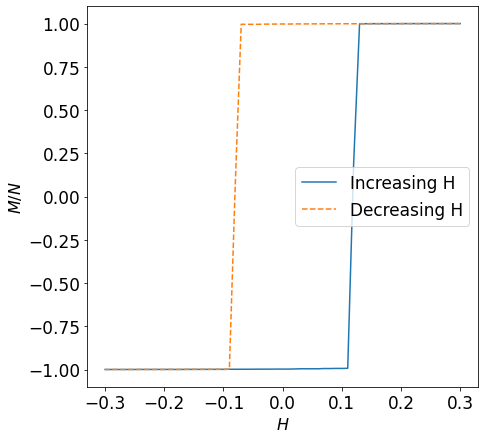

In [36]:
# Plot M/N vs H for all your measurements in this cell
start_time = time.time()
# marking scheme:
#      plot of M/N versus H, as described:   4 marks
#      plot clearly demonstrates hysteresis or otherwise: 4 marks
#      
# YOUR CODE HERE
plt.figure(figsize=(7, 7))
plt.plot(H_values_up, M_per_spin_up, label="Increasing H")
plt.plot(H_values_down, M_per_spin_down,"--", label="Decreasing H")
plt.xlabel(r"$H$")
plt.ylabel(r"$M/N$")
plt.legend()
plt.show()

end_time = time.time()
duration = end_time - start_time

The next cell is worth **2 marks**

In [37]:
# Write a figure caption to your figure and explain why you think the system shows hysteresis (or not)
# Write your answer as code comments, with each line starting with the "#" symbol
# YOUR CODE HERE

# This plot shows the mean magnetisation per spin M/N as a function of the external magnetic field H.
# The blue line represents the magnetisation as H increases from -0.3 to 0.3.
# The orange line represents the magnetisation as H decreases from 0.3 to -0.3.
# The system exhibits hysteresis as the paths of magnetisation during increasing and decreasing H do not overlap, forming a hysteresis loop.

The next cell is worth **4 marks**

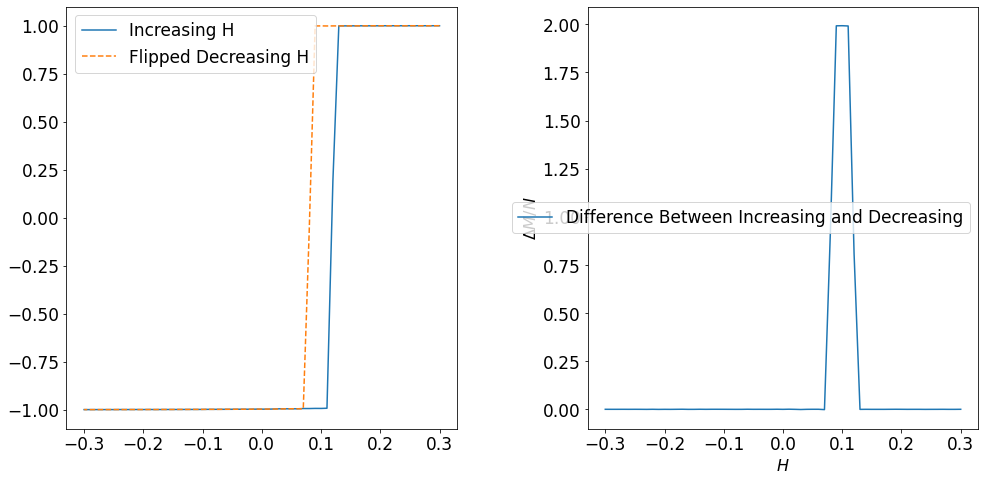

In [38]:
# Use this cell to examine whether the evolution H=-0.3->0.3 and from H=0.3->-0.3 is symmetric in H around H=0
# YOUR CODE HERE

H_values_down_flipped = -np.array(H_values_down[::-1])
M_per_spin_down_flipped = -np.array(M_per_spin_down[::-1])

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].plot(H_values_up, M_per_spin_up, label="Increasing H")
axs[0].plot(H_values_down_flipped, M_per_spin_down_flipped, "--", label="Flipped Decreasing H")
axs[0].legend()

axs[1].plot(H_values_up, M_per_spin_down_flipped[::-1] - M_per_spin_up, label="Difference Between Increasing and Decreasing")
axs[1].legend()
axs[1].set_xlabel(r"$H$")
axs[1].set_ylabel(r"$\Delta M/N$")

plt.tight_layout()
plt.show()

Discuss in the cell below whether the loop is symmetric around $H=0$.
This is worth **2 marks**

In [39]:
# Write your answer as code comments, with each line starting with the "#" symbol
# YOUR CODE HERE

# From the plot, the curve for increasing H (from -0.3 to 0.3) does not perfectly overlap with the flipped curve for decreasing H (from 0.3 to -0.3).
# This indicates that the system exhibits hysteresis, as the magnetization path depends on the history of the applied magnetic field.
# The loop is not symmetric around H = 0, which is consistent with the expected behavior of a system with hysteresis.

Use the cell below to compute the values of the coercivity and retentivity for the Ising model examined in the hysteresis section. Enter the values you find in the cells below.

This is worth **4 marks**

In [40]:
### You may want to use this cell to compute the answer to the questions below.
# YOUR CODE HERE

H_index_up = np.argmin(np.abs(H_values_up))
retentivity = M_per_spin_up[H_index_up]

def find_zero_crossing(H_values, M_values):
    for i in range(len(M_values) - 1):
        if M_values[i] * M_values[i + 1] < 0:
            H0 = H_values[i] - M_values[i] * (H_values[i + 1] - H_values[i]) / (M_values[i + 1] - M_values[i])
            return abs(H0)

coercivity_up   = find_zero_crossing(H_values_up, M_per_spin_up)
coercivity_down = find_zero_crossing(H_values_down, M_per_spin_down)
coercivity = (coercivity_up + coercivity_down) / 2

retentivity, coercivity

(-0.99734375, 0.09952830456574782)

In [65]:
label  = r"The value of the retentivity is (to 2 significant figures, 2 marks)"
label2 = r"Retentivity="
Hyst1=mywidgets.myFloatBox('Hyst','Q1',label2,label)
Hyst1.getWidget()


In [66]:
label  = r"The value of the coercivity is (to 1 significant figures, 2 marks)"
label2 = r"Coercivity ="
Hyst2=mywidgets.myFloatBox('Hyst','Q2',label2,label)
Hyst2.getWidget()

# End of the assignement. Well done!

Before you submit **make sure** you run "validate". If this fails, **then your assignment will fail** This may be the case if (1) cells use to much memory (unlikely) (2) cells take too  much cpu time (more than 5 mins). This may be because the code enters an infinite loop, or the implementation is too inefficient (for example, too small values of Delta H in the hysteresis question).